In [1]:
import dask.dataframe as dd
import datetime
from collections import defaultdict
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import MinMaxScaler

#hierarchical clustering
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
#Kmeans
from sklearn.cluster import KMeans

In [57]:
df_16 = pd.read_csv('gs_16.csv')
df_17 = pd.read_csv('gs_17.csv')
df_18 = pd.read_csv('gs_18.csv')
df_19 = pd.read_csv('gs_19.csv')

In [58]:
df_16['year']  = 2016
df_17['year']  = 2017
df_18['year']  = 2018
df_19['year']  = 2019

In [59]:
df_17.set_index('store',inplace = True)
df_18.set_index('store',inplace = True)
df_19.set_index('store',inplace = True)

In [60]:
df_17['u'] = df_17['u']/12*10
df_17['v'] = df_17['v']/12*10
df_18['u'] = df_18['u']/12*10
df_18['v'] = df_18['v']/12*10

In [61]:
df_1819 = df_19.merge(df_18, right_index = True, left_index = True,suffixes=('_TY', '_LY'))
df = df_1819.merge(df_17, right_index = True, left_index = True)

In [62]:
df.columns = ['u_TY', 'v_TY', 'year_TY', 'u_LY', 'v_LY', 'year_LY', 'u_LLY', 'v_LLY', 'year']
df.drop(columns = ['year_TY','year_LY','year'], inplace = True)

df['u%vsLY'] = df['u_TY']/df['u_LY']-1
df['uLY%vsLLY'] = df['u_LY']/df['u_LLY']-1
df['v%vsLY'] = df['v_TY']/df['v_LY']-1
df['vLY%vsLLY'] = df['v_LY']/df['v_LLY']-1
df['avg_price'] = df['v_TY']/df['u_TY']

df.drop(columns=['u_LY','v_LY','u_LLY','v_LLY'], inplace = True)

In [63]:
df.head(3)

,u_TY,v_TY,u%vsLY,uLY%vsLLY,v%vsLY,vLY%vsLLY,avg_price
store,,,,,,,
1,137834.0,2.353339e+08,0.022324,0.050176,0.067171,0.088084,1707.372162
2,88077.0,1.507813e+08,0.024667,0.062166,0.062164,0.094792,1711.925901
3,138245.0,2.568248e+08,0.034987,0.046643,0.093255,0.074106,1857.751015


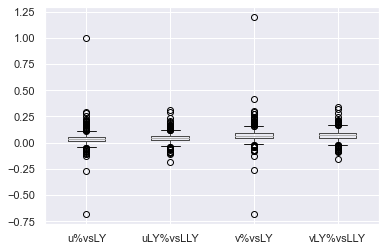

In [64]:
boxplot = df.drop(columns= ['v_TY', 'u_TY', 'avg_price']).boxplot()

let's drop the two stores that are outliers in the value vs LY 

In [65]:
df[(df['v%vsLY']>0.6)]

,u_TY,v_TY,u%vsLY,uLY%vsLLY,v%vsLY,vLY%vsLLY,avg_price
store,,,,,,,
97,87879.0,1.348662e+08,0.993512,0.005188,1.200041,0.019948,1534.680675


In [66]:
df[(df['v%vsLY']<-0.6)]

,u_TY,v_TY,u%vsLY,uLY%vsLLY,v%vsLY,vLY%vsLLY,avg_price
store,,,,,,,
96,18645.0,2.878091e+07,-0.676372,0.045188,-0.684538,0.06421,1543.626298


In [67]:
df = df.drop([96,97], axis = 0)

In [68]:
df_scaled = df.copy()

In [69]:
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df_scaled) 
df_scaled.loc[:,:] = scaled_values

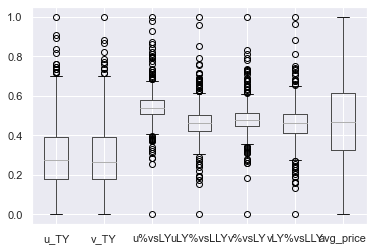

In [70]:
boxplot = df_scaled.boxplot()

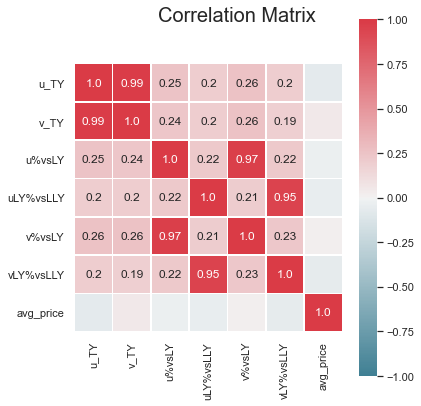

In [71]:
fig = plt.figure(figsize=(6, 6))
# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_scaled.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.4| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.1
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

Because of the high correlation between units and value$, we decided to drop units from the analysis, knowing that its component will be always in the avg_price variable

In [72]:
df_scaled.drop(columns=['u_TY','u%vsLY','uLY%vsLLY'], inplace = True)

#### hierachical clustering

In [73]:
def get_r2_hc(df, link, max_nclus, min_nclus=1, dist="euclidean"):

    def get_ss(matrix):
        mc = matrix - matrix.mean(axis=0)
        return (mc.T@mc).trace() #return sum of squares of matrix
    
    matrix = df.values
    ncols = matrix.shape[1]
    sst = get_ss(matrix) #get total sum of squares
    
    r2 = np.array([]) #where we will store the R2 metrics
    
    for i in range(min_nclus, max_nclus+1):
        Hclustering = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link)
        hclabels = Hclustering.fit_predict(matrix) #get cluster labels
        concat = np.concatenate((matrix, np.expand_dims(hclabels,1)), axis=1)
        ssw = np.array([get_ss(concat[concat[:,ncols]==j, :ncols]) for j in range(i)]).sum() #calculate ssw for a given cluster solution
        r2 = np.append(r2, (sst-ssw)/sst) #save the R2 of the given cluster solution
        
    return r2

In [74]:
number_clusters = 100
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_scaled)

In [75]:
# Characterizing the final clusters
df_concat = pd.concat((df_scaled, pd.Series(km_labels, name='labels')), axis=1)
aa = df_concat.groupby('labels').mean()

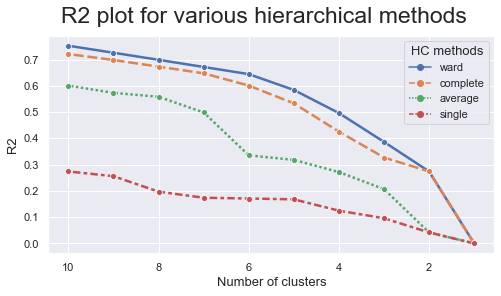

In [76]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Function defined above to obtain the R2 statistic
r2_hc_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_r2_hc(df=aa, link=i, max_nclus=10), 1) for i in hc_methods], axis=1),
                             index=range(1,10+1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(8,4))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=23)
plt.gca().invert_xaxis()
plt.legend(title="HC methods", title_fontsize=13)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2", fontsize=13)

plt.show()

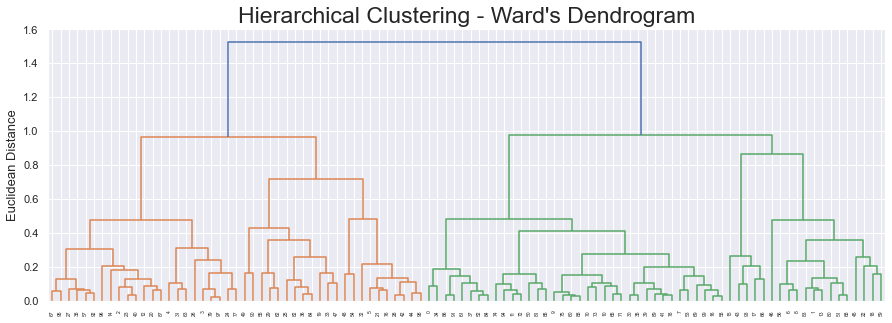

In [77]:
# Hierarchical clustering assessment using scipy
#looking at the graph above we will use the ward method
Z = linkage(aa, method="ward")

sns.set()
fig = plt.figure(figsize=(15,5))

# Dendrogram

dendrogram(Z)

plt.hlines(10, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

### Kmeans

In [78]:
range_clusters = range(1, 15)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_scaled)
    inertia.append(kmclust.inertia_)  

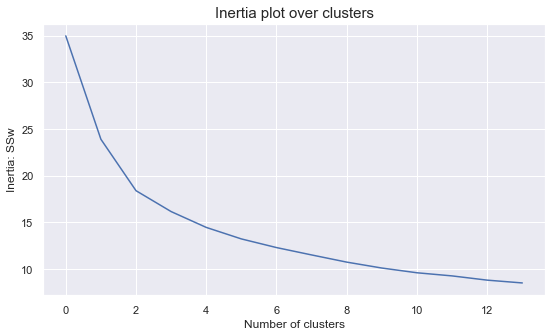

In [79]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [80]:
# final cluster solution. 4 clusters was chosen looking at ward dendogram
number_clusters = 5
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_scaled)

In [81]:
df_reset = df.reset_index()

In [82]:
df_concat = pd.concat((df_reset, pd.Series(km_labels, name='labels')), axis=1)
dataset = df_concat.groupby('labels').mean().round(3)

In [83]:
dataset.sort_values(by = 'avg_price')

,store,u_TY,v_TY,u%vsLY,uLY%vsLLY,v%vsLY,vLY%vsLLY,avg_price
labels,,,,,,,,
4,171.494,88746.918,1.401051e+08,0.026,0.040,0.053,0.063,1582.170
0,122.435,161774.000,2.616529e+08,0.074,0.081,0.110,0.111,1620.056
3,229.294,84401.324,1.433289e+08,0.022,0.031,0.056,0.050,1698.868
2,259.778,196795.667,3.418428e+08,0.043,0.060,0.079,0.080,1738.578
1,236.268,94339.103,1.703056e+08,0.039,0.051,0.076,0.073,1806.512


In [87]:
unique, counts = np.unique(km_labels, return_counts=True)
dict(zip(unique, counts))

{0: 62, 1: 97, 2: 45, 3: 119, 4: 85}

In [84]:
list_of_features

Index(['v_TY', 'v%vsLY', 'vLY%vsLLY', 'avg_price'], dtype='object')

In [85]:
list_of_features = df_scaled.columns
list_of_features_2 = ['v_TY', 'v%vsLY', 'vLY%vsLLY', 'avg_price', 'labels']

In [86]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return(ss)
    

sst = get_ss(df_concat[list_of_features])  # get total sum of squares
ssw_labels = df_concat[list_of_features_2].groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
adj=1-((1-r2)*(10000-1)/(10000-len(list_of_features)-1))
adj

0.6081243662364313

In [36]:
df_concat.to_csv('kmeans_stores_labels.csv')